In [1]:
from ndslib.config import jupyter_startup
jupyter_startup()

(nibabel_transforms)=
# Using nibabel to align different measurements

In the previous section, we saw how to load data from files using Nibabel. Next,
we will go a little bit deeper into how we can use the metadata that is provided
in these files. One of the main problems that we might encounter in analyzing
MRI data is that we would like to combine information acquired using different
kinds of measurements. For example, in the previous section, we read a file
that contains fMRI data. We used the following code:

In [2]:
import nibabel as nib
img_bold = nib.load("ds001233/sub-17/ses-pre/func/sub-17_ses-pre_task-cuedSFM_run-01_bold.nii.gz")
data_bold = img_bold.get_fdata()

In this case, the same person whose fMRI data we just loaded also underwent a
T1-weighted scan in the same session. This image is used to find different parts
of this person's anatomy. For example, it can be used to define where this
person's gray matter is and where the gray matter turns into white matter, just
underneath the surface of the cortex.

In [3]:
img_t1 = nib.load("ds001233/sub-17/ses-pre/anat/sub-17_ses-pre_T1w.nii.gz")
data_t1 = img_t1.get_fdata()

If we look at the meta-data for this file, we will already get a sense that
there might be a problem:

In [4]:
print(img_t1.shape)

(256, 256, 176)


The data is 3-dimensional, and the three first dimensions correspond to the
spatial dimensions of the BOLD data, but the shape of these dimensions does not
correspond to the shape of the first three dimensions of the BOLD data. In this
case, we happen to know that the BOLD was acquired with a spatial resolution of
2mm by 2mm by 2 mm, and the T1-weighted data was acquired with a spatial
resolution of 1mm by 1mm by 1mm. But even taking that into account, multiplying
the size of each dimension of the T1 image by the ratio of the resolutions (a
factor of 2, in this case) does not make things equal. This is because the data
was also acquired using a different field of view: the T1-weighted data covers
256 by 256 mm in each slice (and there are 176 slices, covering 176 mm), while
the BOLD data covers only 96 times 2 = 192mm by 192mm in each slice (and there
are 66 slices, covering only 132 mm). How would we then know how to match a
particular location in the BOLD data to particular locations in the T1-weighted
image? This is something that we need to do if we want to know if a particular
voxel in the BOLD is inside of the brain's gray matter or in another anatomical
segment of the brain.

In addition to the differences in acquisition parameters, we also need to take
into account that the brain might be in a different location within the scanner
in different measurements. This can be because the subject moved between the two
scans, or because the two scans were done on separate days and the head of the
subject was in a different position on these two days. The process of figuring
out the way to bring two images of the same object taken when the object is in
different locations is called *image registration*. We will need to take care of
that too, and we will return to discuss this in {numref}`registration`. But, for
our current discussion, we are going to assume that the subject's brain was in
the same place when the two measurements were made. In the case of this
particular data, this happens to be a good assumption -- probably because these
two measurements were done in close succession, and the subject did not move
between the end of one scan and the beginning of the next one.

But even in this case, we still need to take care of *image alignment*, because
of the differences in image acquisition parameters. Fortunately, the NIfTI file
contains information that can help us align the two volumes to each other,
despite the difference in resolution and field of view.

This information is stored in another piece of metadata in the header of the
file, which is called the "affine matrix". This is a 4-by-4 matrix that contains
information that tells us how the acquisition volume was positioned relative to
the MRI instrument, and relative to the subject's brain, which is inside the
magnet. The affine matrix stored together with the data provides a way to
unambiguously denote the location of the volume of data relative to the scanner.

```{eval-rst}
.. index::
   single: Affine transform
```

### Coordinate frames

To understand how we will use this information, let's first look at a concrete
example of the problem. For example, consider what happens when we take a single
volume of the BOLD data, slice it on the last dimension, so that we get the
middle of the volume on that dimension, and compare it to the middle slice of
the last dimension of the T1-weighted data.

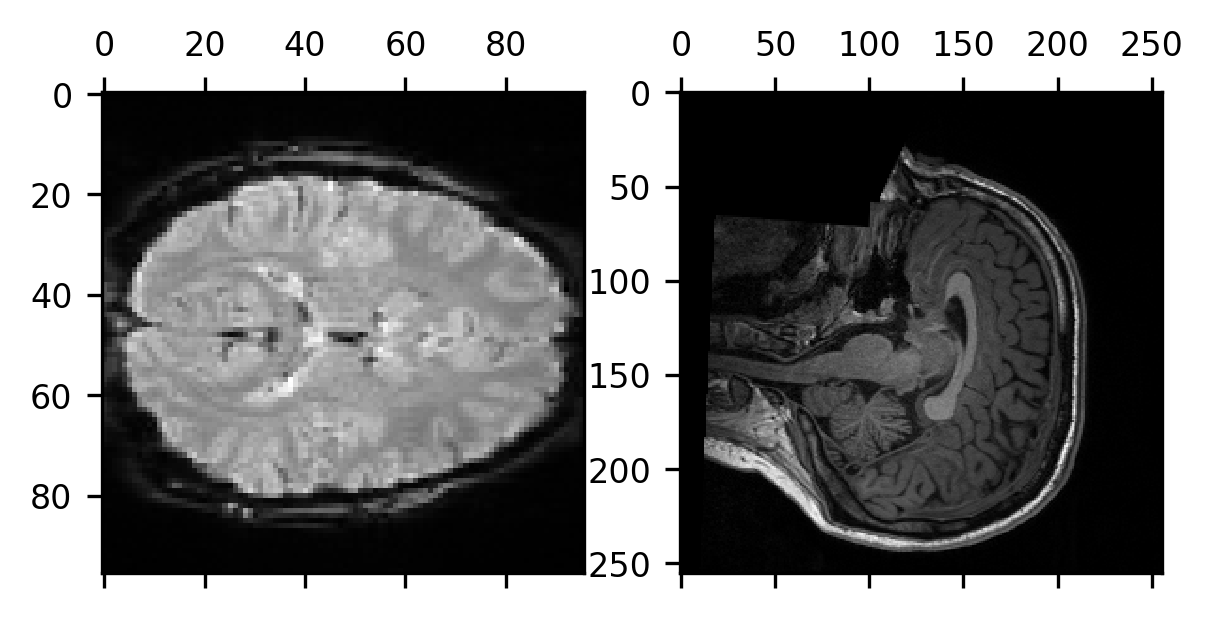

In [5]:
data_bold = img_bold.get_fdata()

data_bold_t0 = data_bold[:, :, :, 0]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
ax[0].matshow(data_bold_t0[:, :, data_bold_t0.shape[-1]//2])
im = ax[1].matshow(data_t1[:, :, data_t1.shape[-1]//2])

These two views of the subject's brain are very different from each other. The
data are not even oriented the same way in terms of the order of the anatomical
axes! While the middle slice on the last spatial dimension for the BOLD data
gives us an axial slice from the data, for the T1-weighted data, we get a
sagittal slice.

To understand why that is the case, we need to understand that the coordinate
frame in which the data is collected can be quite different in different
acquisitions. What do we mean by "coordinate frame"? Technically, a coordinate
frame is defined by an origin and axes emanating from that origin, as well as
the directions and units used to step along the axes. For example, when we make
measurements in the MRI instruments, we define a coordinate frame of the scanner
as one that has the iso-center of the scanner as its origin. This is the point
in the scanner in which we usually place the subject's brain when we make
measurements. We then use the way in which the subject is usually placed into
the MRI bore to explain the convention used to define the axes. In neuroimaging,
this is usually done by placing the subject face up on a bed and then moving the
bed into the magnet with the head going into the MRI bore first (this is
technically known as the "supine, head first" position). Using the subject's
position on the bed, we can define the axes based on the location of the brain
within the scanner. For example, we can define the first (x) axis to be one that
goes from left to right through the subject's brain as they are lying inside the
MRI bore, and the second (y) axis is defined to go from the floor of the MRI
room, behind the back of the subject's brain through the brain and up through
the front of their head towards the ceiling of the MRI room. In terms of the
subject's head, as they are placed in the supine, head first position, this is
the "anterior-posterior" axis. The last (z) axis goes from their feet lying
outside the magnet, through the length of their body, and through the top of
their head (this is "inferior-superior" relative to their anatomy). Based on
these axes, we say that this coordinate frame has the "RAS" (right, anterior,
superior) orientation. This means that the coordinates increase towards the
right side of the subject, towards the anterior part of their brain, and towards
the superior part of their head.

In the spatial coordinate frame of the MRI magnet, we often use millimeters to
describe how we step along the axes. So, specific coordinates in millimeters
point to particular points within the scanner. For example, the coordinate
`[1, 0, 0]` is one millimeter to the right of the isocenter (where right is defined
as the direction to the subject's right as they are lying in there). Following
this same logic, negative coordinates can be used to indicate points that are to
the left, posterior, and inferior of the scanner iso-center (again, relative to
the subject's brain). So, the coordinate `[-1, 0, 0]` indicates a point that is
1mm to the left of the iso-center. The RAS coordinate system is a common way to
define the scanner coordinate frame, but you can also have LPI (which goes
right-to-left, anterior-to-posterior, and superior-to-inferior instead) or any
combination of directions along these principal directions (RAI, LPS, ...,
etc.).

(nibabel_transforms_ex1)=
#### Exercise

What is the location of `[1, 1, 1]` RAS in the LAS coordinate frame?

Given that we know where particular points are in space relative to the magnet
iso-center, how can we tell where these particular points are in the numpy array
that represents our data? For example, how would we translate the coordinate
`[1,0,0]` in millimeters into an index `[i,j,k]`, which we can use to index into
the array to find out what the value of the MRI data is in that location?

The volume of data is acquired with a certain orientation, a certain field of
view, and a certain voxel resolution. This means that the data also has a spatial
coordinate frame. The `[0, 0, 0]` coordinate indicates the voxel that is the
array coordinate `[0, 0, 0]` (that is, `i=0`, `j=0`, and `k=0`) and the axes are
the axes of the array. For example, the BOLD data we have been looking at here
is organized such that `[0, 0, 0]` is somewhere inferior and posterior to their
head. We can tell that by plotting several slices of the brain starting at slice
20, going to the middle slice, and then up to slice 46 (20 slices from the end of
the array in that direction).

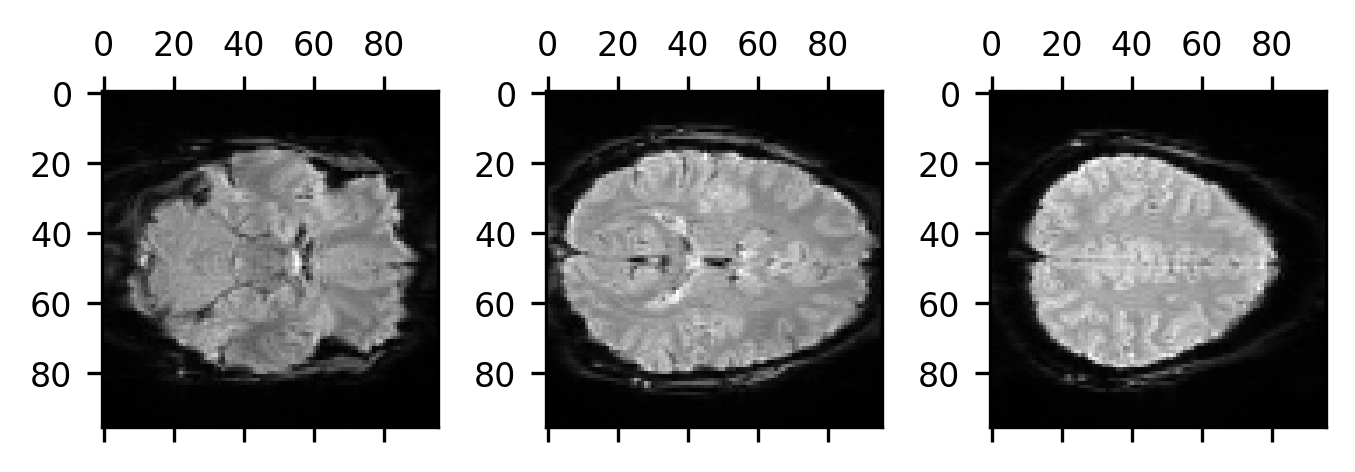

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3)
ax[0].matshow(data_bold_t0[:, :, 20])
ax[1].matshow(data_bold_t0[:, :, data_bold_t0.shape[-1]//2])
ax[2].matshow(data_bold_t0[:, :, 46])
fig.set_tight_layout("tight")

Based on our knowledge of anatomy, we see that the first slice is lower in the
head than the middle slice, which is lower in the head than the third slice.
This means that as we increase the coordinate on the last dimension we are going
up in the brain. So, we know at least that the last coordinate is an "S". Based
on the labeling of the axis, we can also see that the second dimension increases
from the back of the brain to the front of the brain, meaning that the second
coordinate is an "A". So far, so good. What about the first dimension? We might
be tempted to think that since it looks like it's increasing from left to right
that must be an "R". But this is where we need to pause for a bit. This is
because there is nothing to tell us whether the brain is right-left flipped.
This is something that we need to be particularly careful with (right-left flips
are a major source of error in neuroimaging data analysis!).

(nibabel_transforms_ex2)=
#### Exercise

Based on the anatomy, what can you infer about the coordinate frame in which the T1w data was acquired?

We see that we can guess our way toward the coordinate frame in which the data
was acquired, but as we already told you above, there is one bit of data that
will tell you unambiguously how to correspond between the data and the scanner
coordinate frame. To use this bit of data to calculate the transformation
between different coordinate frames, we are going to use a mathematical
operation called matrix multiplication. If you have never seen this operation
before, you can learn about it in the section below. Otherwise, you can skip on
to {numref}`use_affine`.

---

**Matrix multiplication**

```{eval-rst}
.. index::
   single: Matrix multiplication
```

**Matrices, vectors and their multiplication**

A matrix is a collection of numbers that are organized in a table with rows and
columns. Matrices (the plural of "matrix") look a lot like two-dimensional
Numpy arrays, and Numpy arrays can be used to represent matrices.

In the case where a matrix has only one column or only one row, we call it a
vector. If it has only one column and only one row -- it is just a single number
-- we refer to it as a scalar.

Let's look at an example. The following is a 2-by-3 matrix:

```{math}
   A = \begin{bmatrix} a & b & c \\
                       d & e & f \end{bmatrix}
```

The following is a 3-vector, with one row (we'll use a convention where matrices
are denoted by capital letters and vectors are denoted by lower-case letters):

```{math}

    v = \begin{bmatrix} a & b & c \end{bmatrix}

```

We can also write the same values into a vector with three rows and one column:

```{math}

    v = \begin{bmatrix} a \\ b \\ c \end{bmatrix}

```

In the most general terms, the matrix multiplication between the $m$-by-$n$
matrix $A$ and the $n$-by-$p$ matrix $B$ is a an m-by-p matrix. The entry on row
$i$ and column $j$ in the resulting matrix, $C$ is defined as:

```{math}

C_{i,j} = \sum_{k=1}^{n}{A_{i,k}B_{k,j}}

```

If this looks a bit mysterious, let's consider an example and work out the
computations of individual components. Let's consider:

```{math}

    A = \begin{bmatrix} 1 & 2 & 3 \\ 4 & 5 & 6 \end{bmatrix}

```

```{math}

    B = \begin{bmatrix} 7 & 8 \\ 9 & 10 \\ 11 & 12 \end{bmatrix}

```

The first matrix $A$ is a 2-by-3 matrix, and the second matrix, $B$ is a 3-by-2
matrix. Based on that, we already know that the resulting multiplication, which
we write as $C=AB$ will be a 2-by-2 matrix.

Let's calculate the entries in this matrix one by one. Confusingly enough, in
contrast to Python sequences, when we do math with matrices, we index them using
a one-based indexing system. This means that the first item in the first row of
this matrix is $C_{1,1}$. The value of this item is:

```{math}

C_{1,1} = \sum_{k=1}^{3}{A_{1,k}B_{k,1}}

= A_{1,1} B_{1,1} + A_{1,2} B_{2,1} + A_{1,3} B_{3,1}

= 1 \cdot 7 + 2 \cdot 9 + 3 \cdot 11 = 58

```

Similarly, the value of $C_{1,2}$ is:

```{math}

C_{1,2} = \sum_{k=1}^{3}{A_{1,k}B_{k,2}}

= A_{1,1} B_{1, 2} + A_{1, 2} B_{2, 2} + A_{1, 3} B_{3, 2}

= 1 \cdot 8 + 2 \cdot 10 + 3 \cdot 12 = 64

```

And so on... At the end of it all, the matrix $C$ will be:

```{math}

    C = \begin{bmatrix} 58 & 64 \\ 139 & 154 \end{bmatrix}

```

(nibabel_transforms_ex3)=
#### Exercises

1. Convince yourself that the answer we gave above is correct by computing the components of the second row following the formula.
2. Write a function that takes two matrices as input and computes their multiplication.

### Multiplying matrices in Python

Fortunately, Numpy already implements a (very fast and efficient!) matrix multiplication for matrices and vectors that are represented with Numpy arrays. The standard multiplication sign `*` is already being used in Numpy for element-by-element multiplication (see {numref}`numpy`), so another symbol was adopted for matrix multiplication: `@`. As an example, let's look at the matrices $A$, $B$ and $C$ we used above [^1]

[^1]: There is also a function that implements this multiplication: `np.dot(A, B)` is equivalent to `A @ B`

In [7]:
import numpy as np
A = np.array([[1, 2, 3], [4, 5, 6]])

B = np.array([[7, 8], [9, 10], [11, 12]])

C = A @ B

print(C)

[[ 58  64]
 [139 154]]


(use_affine)=
## Using the affine

```{eval-rst}
.. index::
   single: Affine
```

The way that the affine information is used requires a little bit of knowledge of matrix multiplication. If you are not at all familiar with this idea, a brief introduction, which includes pretty much everything you need to know about this topic to follow along from here, is provided above.

### Coordinate transformations

One particularly interesting case of matrix multiplication is the multiplication
of vectors of length $n$ with an $n$-by-$n$ matrix. This is because the input
and the output in this case have the same number of entries. Another way of
saying that is that the dimensionality of the input and output is identical. One
way to interpret this kind of multiplication is to think of it as taking one
coordinate in a space defined by $n$ coordinates and moving it to another
coordinate in that $n$-dimensional space. This idea is used as the basis for
transformations between the different coordinate spaces that describe where our
MRI data is.

Let's think about some simple transformations of coordinates. One kind of transformation is a scaling transformation. This takes a coordinate in the $n$-dimensional space (for example, in the $2$-dimensional space `[x, y]`) and sends it to a scaled version of that coordinate (for example, to `[a*x, b*y]`). This transformation is implemented through a diagonal matrix. Here is the $2$-dimensional case:

```{math}
    \begin{bmatrix} a & 0 \\ 0 & b \end{bmatrix}
```

If you are new to matrix multiplications, you might want to convince yourself that this matrix does indeed implement the scaling, by working through the math of this example element by element. Importantly, this idea is not limited to two dimensions, or any particular dimensionality for that matter. For example, in the $3$-dimensional case, this would be:

```{math}

\begin{bmatrix} a & 0 & 0 \\ 0 & b & 0 \\ 0 & 0 & c \end{bmatrix}

```

and it would scale `[x, y, z]` to `[a*x, b*y, c*z]`.

Another interesting transformation is what we call a rotation transformation. This takes a particular coordinate and rotates it around an axis.

```{math}

A_{\theta} = \begin{bmatrix} cos(\theta) & -sin(\theta) \\ sin(\theta) & cos(\theta) \end{bmatrix}

```

What does it mean to rotate a coordinate around the axis? Imagine that the
coordinate `[x, y]` is connected to the origin with a straight line. When we
multiply that coordinate by our rotation matrix $A_\theta$, we are rotating that
line around the axis by that angle. It's easier to understand this idea through
an example with code, and with a visual. The code below defines an angle `theta`
(in radians) and the two-dimensional rotation matrix `A_theta`, and then
multiplies a two-dimensional coordinate `xy` (plotted as a circle marker), which
produces a new coordinate `xy_theta` (plotted with a square marker). We connect
each coordinate to the origin (the coordinate `[0, 0]`) through a line: the
original coordinate with a solid line and the new coordinate with a dashed line.
The angle between these two lines is $\theta$.

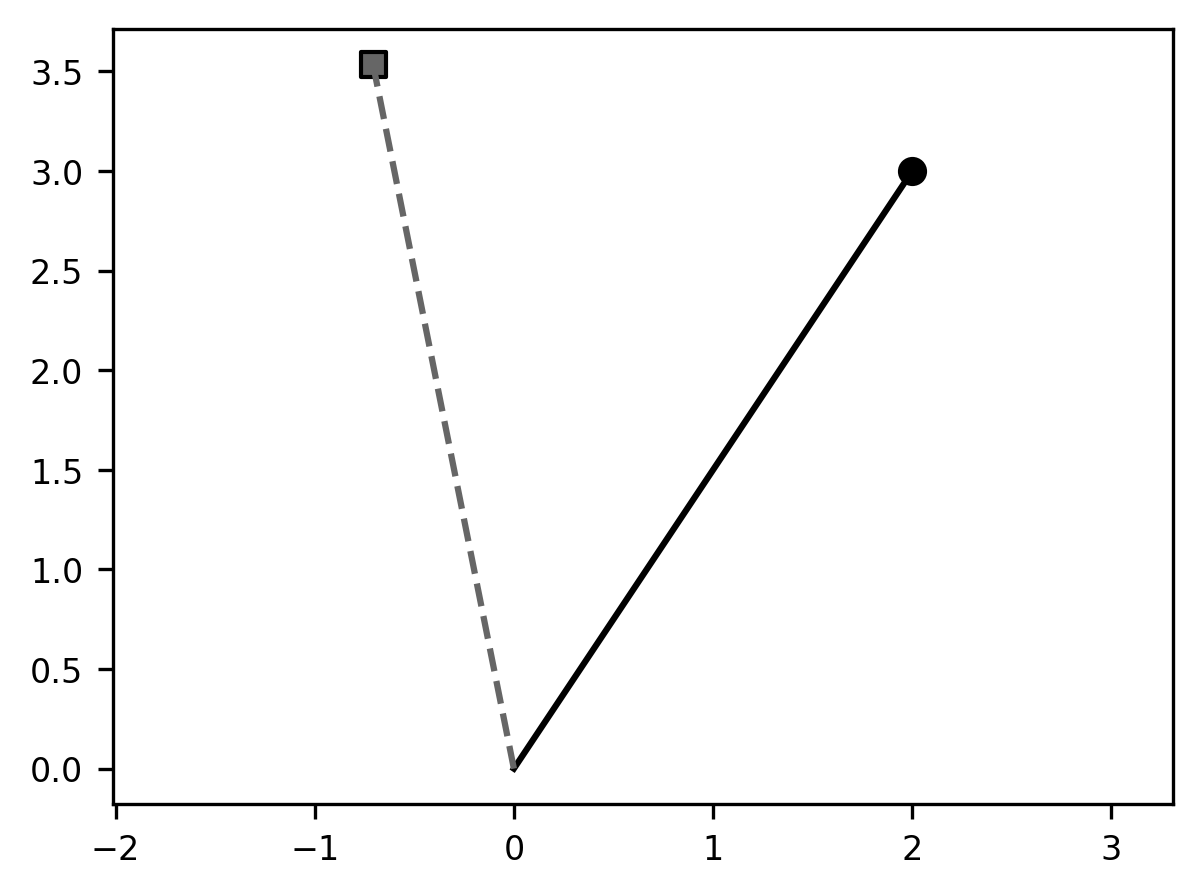

In [8]:
theta = np.pi/4
A_theta = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
xy = np.array([2, 3])
xy_theta = A_theta @ xy

fig, ax = plt.subplots()
ax.scatter(xy[0], xy[1])
ax.plot([0, xy[0]], [0, xy[1]])
ax.scatter(xy_theta[0], xy_theta[1], marker='s')
ax.plot([0, xy_theta[0]], [0, xy_theta[1]], '--')
p = ax.axis("equal")

This idea can be expanded to three dimensions, but in this case, we define a
separate rotation matrix for each of the axes. The rotation by angle $\theta$
around the x-axis is defined as:

```{math}

A_{\theta,x} = \begin{bmatrix} 1 & 0 & 0 \\ 0 & cos(\theta) & -sin(\theta) \\ 0 & sin(\theta) & cos(\theta) \end{bmatrix}
```

The rotation by angle $\theta$ around the y-axis is defined as:

```{math}

    A_{\theta,y} = \begin{bmatrix} cos(\theta) & 0 & -sin(\theta) \\ 0 & 1 & 0 \\ sin(\theta) & 0 & cos(\theta)\end{bmatrix}
```

This leaves the rotation by angle $\theta$ around the z-axis, defined as:

```{math}
A_{\theta,z} = \begin{bmatrix} cos(\theta) & -sin(\theta) & 0 \\ sin(\theta) & cos(\theta) & 0 \\ 0 & 0 & 1  \end{bmatrix}
```

### Composing transformations

The transformations defined by matrices can be *composed* into new
transformations. This is a technical term that means that we can do one
transformation followed by another transformation, and that would be the same as
multiplying the two transformation matrices by each other and then using the product.
In other words, matrix multiplication is associative:

$(A B) v = A (B v)$

For example, we can combine scaling and rotation:

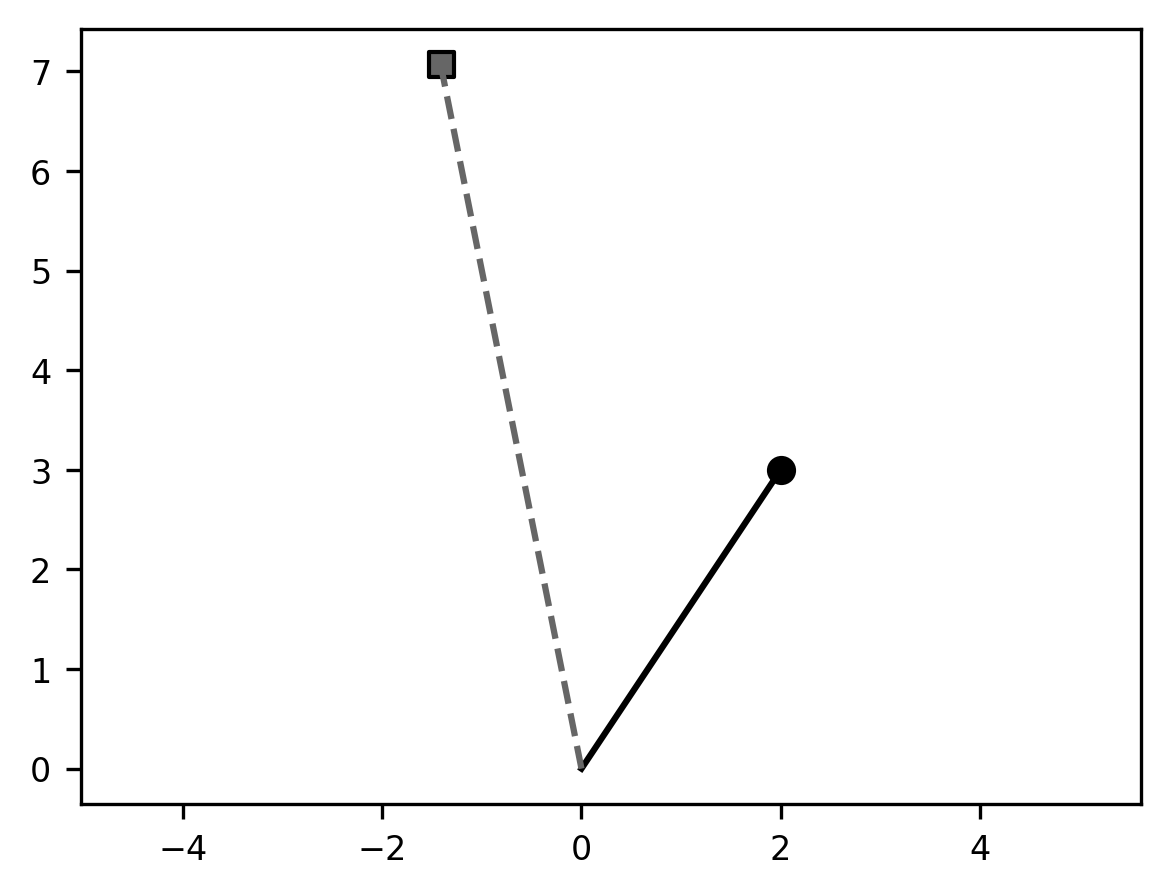

In [9]:
theta = np.pi/4
A_theta = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
B = np.array([[2, 0], [0, 2]])
xy = np.array([2, 3])
xy_transformed = A_theta @ B @ xy

fig, ax = plt.subplots()
ax.scatter(xy[0], xy[1])
ax.plot([0, xy[0]], [0, xy[1]])
ax.scatter(xy_transformed[0], xy_transformed[1], marker='s')
ax.plot([0, xy_transformed[0]], [0, xy_transformed[1]], '--')
p = ax.axis("equal")

Comparing this to the previous result, you can see that the angle between the
solid line and the dashed line is the same as it was in our previous example,
but the length of the dashed line is now twice as long as the length of the
solid line. This is because we applied both scaling and rotation. Notice
also that following the associativity rule that we describe above the line
`xy_transformed = A_theta @ B @ xy` could be written
`xy_transformed = (A_theta @ B) @ xy` or `xy_transformed = A_theta @ (B @ xy)` and
the result would be the same.

Another thing to consider is that every coordinate in the 2D space that we would
multiply with this matrix would undergo the same transformation, relative to the
origin: it would be rotated counterclockwise by an angle theta and moved to be
twice as far from the origin as it previously was. In other words, the matrix
performs a *coordinate transformation*.

Now, using this idea, we can start thinking about how we might describe data
represented in one coordinate frame -- the scanner space measured in millimeters
-- to another coordinate frame -- the representation of the data in the array of
acquired MRI data. This is done using a matrix that describes how each `[x,y,z]`
position in the scanner space is transformed in an `[i,j,k]` coordinate in the
array space.

Let's think first about the scaling: if each voxel is 2-by-2-by-2 millimeters in
size, that means that for each millimeter that we move in space, we are moving
by half a voxel. A matrix that would describe this scaling operation would look
like this:

```{math}

    A_{scale} = \begin{bmatrix} 0.5 & 0 & 0 \\ 0 & 0.5 & 0 \\ 0 & 0 & 0.5 \end{bmatrix}

```

The next thing to think about is the rotation of the coordinates: this is
because when we acquire MRI data, we can set the orientation of the acquisition
volume to be different from the orientation of the scanner coordinate frame. It
can be tilted relative to the scanner axes in any of the three dimensions, which
means that it could have rotations around each of the axes. So, we would combine
our scaling matrix with a series of rotations:

```{math}

    A_{total} = A_{scale} A_{\theta, x} A_{\theta, y} A_{\theta, z}

```

But even after we multiply each of the coordinates in the brain in millimeters
by this matrix, there is still one more operation that we need to do to move to
the space of the MRI acquisition. As we told you above, the origin of the
scanner space is in the iso-center of the magnet. But the MRI acquisition
usually has its origin somewhere outside of the subject's head, so that it
covers the entire brain. So, we need to move the origin of the space from the
iso-center to the corner of the scanned volume. Mathematically, this translates
to shifting each coordinate `[x, y, z]` in the scanner space by [$\Delta
x$,$\Delta y$, $\Delta z$], where each one of these components describes where
the corner of the MRI volume is relative to the position of iso-center.

Unfortunately, this is not an operation that we can do by multiplying the
coordinates with a 3-by-3 matrix of the sort that we saw above. Instead, we will
need to use a mathematical trick: instead of describing each location in the
space via a three-dimensional coordinate `[x, y, z]`, we will add a dimension to
the coordinates, so that they are written as `[x, y, z, 1]`. We then also make
our matrix a 4-by-4 matrix:


```{math}

    \begin{bmatrix}  &  &  & \Delta x \\  & A_{total} &  & \Delta y\\ &  &  & \Delta y \\ 0 & 0 & 0 & 1 \end{bmatrix}

```

where $A_{total}$ is the matrix composed of our rotations and scalings. This might look like a weird thing to do, but an easy way to demonstrate that this shifts the origin of the space is to apply a matrix like this to the origin itself, which we have augmented with a 1 as the last element: `[0, 0, 0, 1]`. To make the example more straightforward, we will also set $A_{total}$ to be a matrix with ones in the elements on the diagonal and all other elements set to 0. This matrix is called an *identity matrix* because when you multiply an n-dimensional vector with a matrix that is constructed in this manner, the result is identical to the original vector (use the formula in {ref}`matmul`, or create this matrix with code to convince yourself of that!).

In [10]:
A_total = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
delta_x = 128
delta_y = 127
delta_z = 85.5
A_affine = np.zeros((4, 4))
A_affine[:3, :3] = A_total
A_affine[:, 3] = np.array([delta_x, delta_y, delta_z, 1])

origin = np.array([0, 0, 0, 1])

result = A_affine @ origin
print(result)

[128.  127.   85.5   1. ]


As you may have noticed, in the code, we called this *augmented transformation matrix* an *affine* matrix. We will revisit affine transformations later in the book (when we use these transformations to process images in {numref}`registration`). For now, we simply recognize that this is the name used to refer to the 4-by-4 matrix that is recorded in the header of neuroimaging data and tells you how to go from coordinates in the scanner space to coordinates in the image space. In nibabel, these transformations are accessed via:

In [11]:
affine_t1 = img_t1.affine
affine_bold = img_bold.affine

Where do these affines send the origin?

In [12]:
print(affine_t1 @ np.array([0, 0, 0, 1]))

[ -85.5  128.  -127.     1. ]


This tells us that the element indexed as `data_t1[0, 0, 0]` lies 85.5 mm to the
left of the isocenter, 128 mm anterior to the isocenter (towards the ceiling of
the room) and 127 mm inferior to the isocenter (towards the side of the room where
the subject's legs are sticking out of the MRI).

(nibabel_transforms_ex4)=
#### Exercise

Where in the scanner is the element `data_bold[0, 0, 0]`? Where is `data_bold[-1, -1, -1]`? (hint: `affine_bold @ np.array([-1, -1, -1, 1]` is not going to give you the correct answer).

### The inverse of the affine

The *inverse* of a matrix is a matrix that does the opposite of what the
original matrix did. The inverse of a matrix is denoted by adding a "-1" in the
exponent of the matrix. For example, for the scaling matrix:

```{math}

    B = \begin{bmatrix} 2 & 0 \\ 0 & 2 \end{bmatrix}

```

the inverse of $B$ is called $B^{-1}$. Since this matrix sends a coordinate to
be twice as far from the origin, its inverse would send a coordinate to be half
as far from the origin. Based on what we already know, this would be:

```{math}

    B^{-1} = \begin{bmatrix} 0.5 & 0 \\ 0 & 0.5 \end{bmatrix}

```

Similarly, for a rotation matrix:


```{math}

    A_{\theta} = \begin{bmatrix} cos(\theta) & -sin(\theta) \\ sin(\theta) & cos(\theta) \end{bmatrix}

```

the inverse is the matrix that rotates the coordinate around the same axis by
the same angle, but in the opposite direction, so:

```{math}

    A_{\theta^{-1}} = \begin{bmatrix} cos(-\theta) & -sin(-\theta) \\ sin(-\theta) & cos(-\theta) \end{bmatrix}

```

(nibabel_transforms_ex5)=
#### Exercise

The inverse of a rotation matrix is also its *transpose*, the matrix that has the rows and columns exchanged. Use the math you have seen so far (and hint: also a bit of trigonometry) to demonstrate that this is the case.


### Computing the inverse of an affine in Python

It will come as no surprise that there is a way to compute the inverse of a
matrix in Python. That is the numpy function: `np.linalg.inv`. As you can see
from the name it comes from the `linalg` sub-module (`linalg` stands for "Linear
Algebra", which is the field of mathematics that deals with matrices and
operations on matrices). For example, the inverse of the scaling matrix $B$ is
computed as follows:

In [13]:
B_inv = np.linalg.inv(B)
print(B_inv)

[[0.5 0. ]
 [0.  0.5]]


Why do we need the inverse of a neuroimaging data file's affine? That is because
we already know how to go from one data file's coordinates to the scanner space,
but if we want to go from one data file's coordinates to another data file's
coordinates, we will need to go from one data file to the scanner and then from
the scanner coordinates to the other data file's coordinates. The latter part
requires the inverse of the second affine.

For example, consider what we need to do if we want to know where the central
voxel in the BOLD acquisition falls in the space of the T1-weighted acquisition.
First, we calculate the location of this voxel in the `[i, j, k]` coordinates of
the BOLD image space:

In [14]:
central_bold_voxel = np.array([img_bold.shape[0]//2,
                               img_bold.shape[1]//2,
                               img_bold.shape[2]//2, 1])

Next, we move this into the scanner space, using the affine transform of the BOLD image:

In [15]:
bold_center_scanner = affine_bold @ central_bold_voxel
print(bold_center_scanner)

[  2.         -19.61000896  16.75154221   1.        ]


Again, to remind you, these coordinates are now in millimeters, in scanner space. This means that this voxel is located 2 mm to the right, almost 20 mm posterior, and almost 17 mm superior to the MRI iso-center.

Next, we use the *inverse* of the T1-weighted affine to move this coordinate
into the space of the T1-weighted image space.

In [16]:
bold_center_t1 = np.linalg.inv(affine_t1) @ bold_center_scanner
print(bold_center_t1)

[147.61000896 143.75154221  87.5          1.        ]


This tells us that the time series in the central voxel of the BOLD volume comes
approximately from the same location as the T1-weighted data in `data_t1[147 143
87]`. Because the data are sampled a little bit differently and the resolution
differs, the boundaries between voxels are a little bit different in each one of
these modalities recorded. If you want to put them in the same space, you will
also need to compensate for that. We will not show this in detail, but you
should know that the process of alignment uses forms of data interpolation or
smoothing to make up for these discrepancies, and these usually have a small
effect on the values in the data. For example, resampling the data from the BOLD
space to the T1 space and then back would not necessarily give you the same
values you started with.

Taking all these facts together, we are now ready to align our data with each
other. Fortunately, nibabel implements a function that allows us to take one
NIfTI image and resample it into the space of another image. This function takes
a `NiFTI1` image object input and the shape and affine matrix of the space into
which you would like to resample the data. So, we can go ahead and resample the
T1-weighted image to the space and resolution of the BOLD data:

In [17]:
from nibabel.processing import resample_from_to
img_t1_resampled = resample_from_to(img_t1, (img_bold.shape[:3], img_bold.affine))

The image that results from this computation has the shape of the BOLD data, as
well as the affine of the BOLD data:

In [18]:
print(img_t1_resampled.shape)
print(img_t1_resampled.affine == img_bold.affine)

(96, 96, 66)
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


And, importantly, if we extract the data from this image, we can show that the
two data modalities are now well aligned:

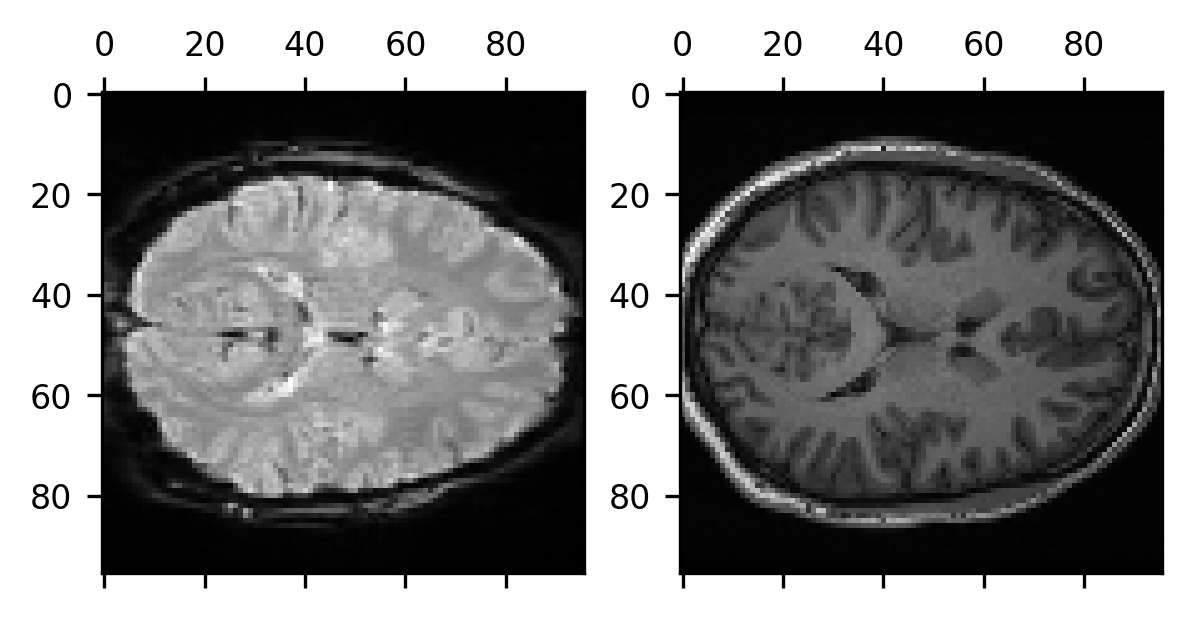

In [19]:
data_t1_resampled = img_t1_resampled.get_fdata()

fig, ax = plt.subplots(1, 2)
ax[0].matshow(data_bold_t0[:, :, data_bold_t0.shape[-1]//2])
im = ax[1].matshow(data_t1_resampled[:, :, data_t1_resampled.shape[-1]//2])

Finally, if you would like to write out this result into another NIfTI file, to
be used later in some other computation, you can do so by using Nibabel's save
function:

In [20]:
nib.save(nib.Nifti1Image(data_t1_resampled, img_t1_resampled.affine),
         't1_resampled.nii.gz')

(nibabel_transforms_ex6)=
#### Exercises

1. Move the first volume of the BOLD data into the T1-weighted space and show that they are well aligned in that space. Save the resulting data into a new NIfTI file.

2. In which direction would you expect to lose more information to interpolation/smoothing? Going from the BOLD data to the T1-weighted data, or the other way around?

## Additional resources

Another explanation of coordinate transformations is provided in [the nibabel documentation](https://nipy.org/nibabel/coordinate_systems.html).